# Homework 8
D. James

In [1]:
from scipy.io import loadmat
from numpy import exp,sin,pi,mean,sqrt,zeros,std
import matplotlib.pyplot as plt
import datetime as dt
now = dt.datetime.now().strftime("%Y-%m-%d")
convSecYr = 1/6690

## Problem 1: Lab Data
### Introduction
The data was recorded on Tuesday night, so the AC was still an active process and the light operated every 10 secs.

In [ ]:
import dataAcquisition as daq
from time import time,sleep
from scipy.io import savemat

In [ ]:
# initial values for arduino
port = '/dev/ttyUSB0'
res = [9.88,10.04,9.83,10,9.97,10]
dur = 7200
step = 1

# Arduino machine starting up
# probably not evil
hal9001 = daq.DAQ(port,res,dur,step)

a = 9.57e-04
b = 3.15e-04
c = -1.17e-05
d = 6.23e-07

In [ ]:
# starting timer
start_time = time()
timepoints = []
view_time = 5
duration = dur
pause = step

run = True;

counter = 0
# loop that collects data points
while run:
    # get current moment of time
    timepoints.append(time()-start_time)
    current_time = timepoints[-1]
    
    j = 0
    for i in hal9001:
        # nested equation is the voltage reading
        # next level calculates the resistance
        # final level calculates temperature
        temp = i.calcTemperature(i.calcResistance(i.readVoltage()),a,b,c,d)
        
        # records values
        i.recoValue(counter,temp)
        j+=1
    counter+=1
    
    # intermittent save
    if(counter%300 == 0):
        hal9001.saveData(timepoints)
        for i in hal9001:
            volt = i.readVoltage()
            res = i.calcResistance(volt)
            temp = i.calcTemperature(res,a,b,c,d)
            print(i,temp)
        
    # if time passes duration, exit out of loop
    if timepoints[-1] > duration:
        run=False
        
    # pause for a moment to collect values consistently
    sleep(pause)
    
# final save of data
hal9001.cleanData()
hal9001.saveData()

In [2]:
# reloading the data
data = loadmat('20190305-2132data.mat')
channels = data['channels']
time = data['time'][0]

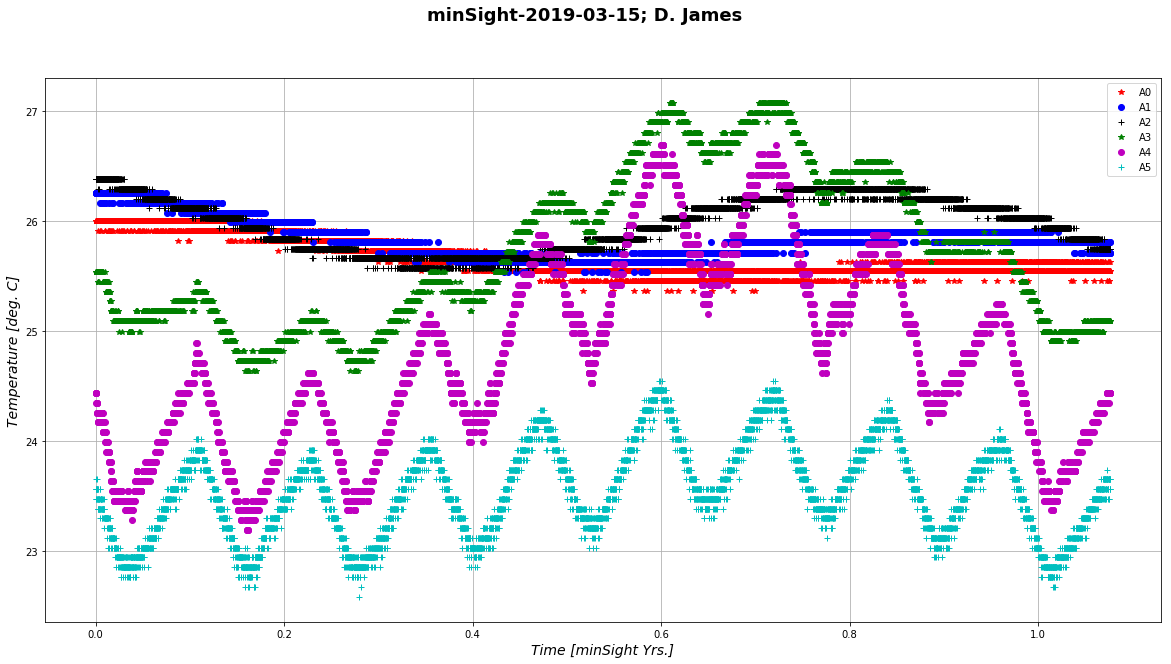

In [3]:
# plot all of the data collected
fig1 = plt.figure(figsize=(20,10))
fig1.suptitle('minSight-'+now+'; D. James', fontsize='18', fontweight='bold')
plt.xlabel('Time [minSight Yrs.]', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature [deg. C]', fontsize='14', fontstyle='italic')
plt.grid(True)

styles = ['r*','bo','k+','g*','mo','c+']
labels = ['A0','A1','A2','A3','A4','A5']

for i in range(0,len(channels)):
    plt.plot(time*convSecYr,channels[i],styles[i],label=labels[i])
    
plt.legend()
fig1.show()
fig1.savefig(now+'plot.png')

## Problem 2: Theory Plot
- $T(z_i,t)=T_{0_i}+\Delta Te^{-(z_i-z_0)/\delta}\sin{(\frac{2 \pi t}{P}-\frac{z_i-z_0}{\delta} + \phi)}$
    - where $ \delta = \sqrt{\kappa P/\pi} $

In [4]:
# loading the data needed
data = loadmat('20190305-2132data.mat')
Temp = data['channels']
time = data['time'][0]
roomTemp = Temp[4:]
sandTemp = Temp[0:4]
# levels of z heights in mm
z = [42e-3,28e-3,14e-3,1e-3]

# mean temperatures at each thermistor
leng = sandTemp.shape[0]
meanTemp = zeros(leng)
for i in range(0,leng):
    meanTemp[i] = mean(Temp[i])

In [5]:
# T with theoretical values
def T(z,t,T0):
    kappa = 3e-7
    z0 = 0
    P = 669*10
    delta = sqrt(kappa*P/pi)
    deltaT = 1.6
    
    return T0+deltaT*exp(-z/delta)*sin(2*pi*t/P-z/delta+7*pi/8)

In [6]:
theoryTemp = []
# calculates theoretical temperature
for i in range(0,leng):
    theoryTemp.append(T(z[i],time,meanTemp[i]))

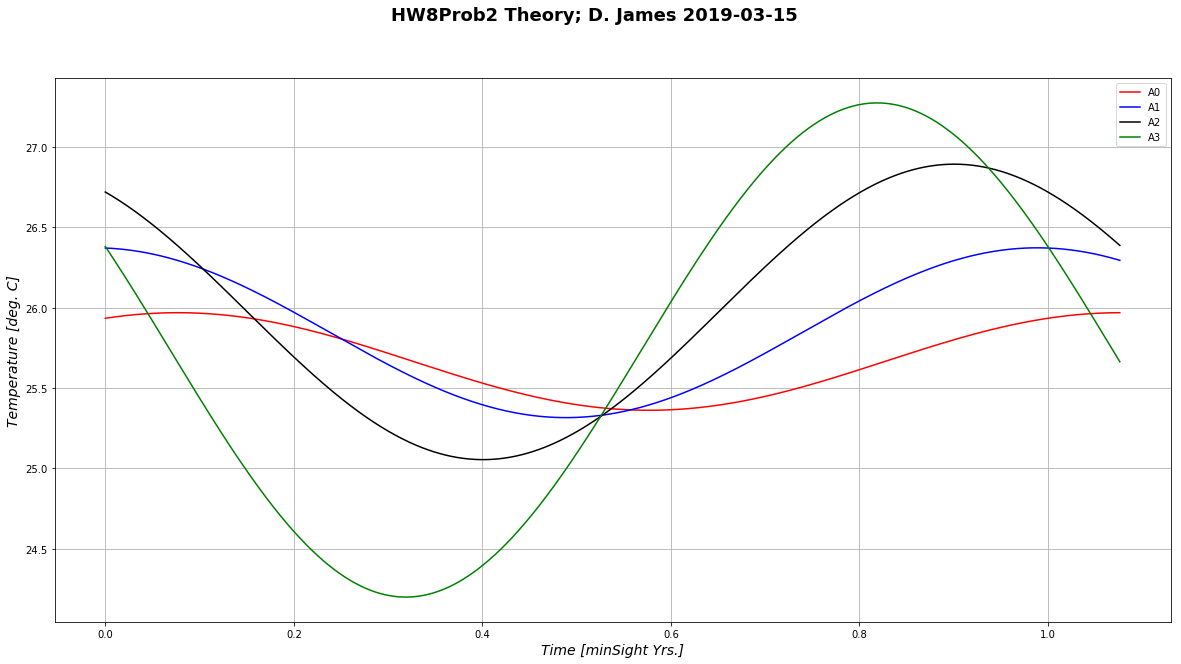

In [7]:
# plotting theoretical values
fig2 = plt.figure(figsize=(20,10))

fig2.suptitle('HW8Prob2 Theory; D. James '+now, fontsize='18', fontweight='bold')
plt.xlabel('Time [minSight Yrs.]', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature [deg. C]', fontsize='14', fontstyle='italic')
plt.grid(True)

styles = ['r','b','k','g']
rawSty = ['r.','b.','k.','g.']
labels = ['A0','A1','A2','A3']

for i in range(0,leng):
    plt.plot(time*convSecYr,theoryTemp[i],styles[i],label=labels[i])
    
plt.legend()
fig2.show()
fig2.savefig(now+'plot2.png')

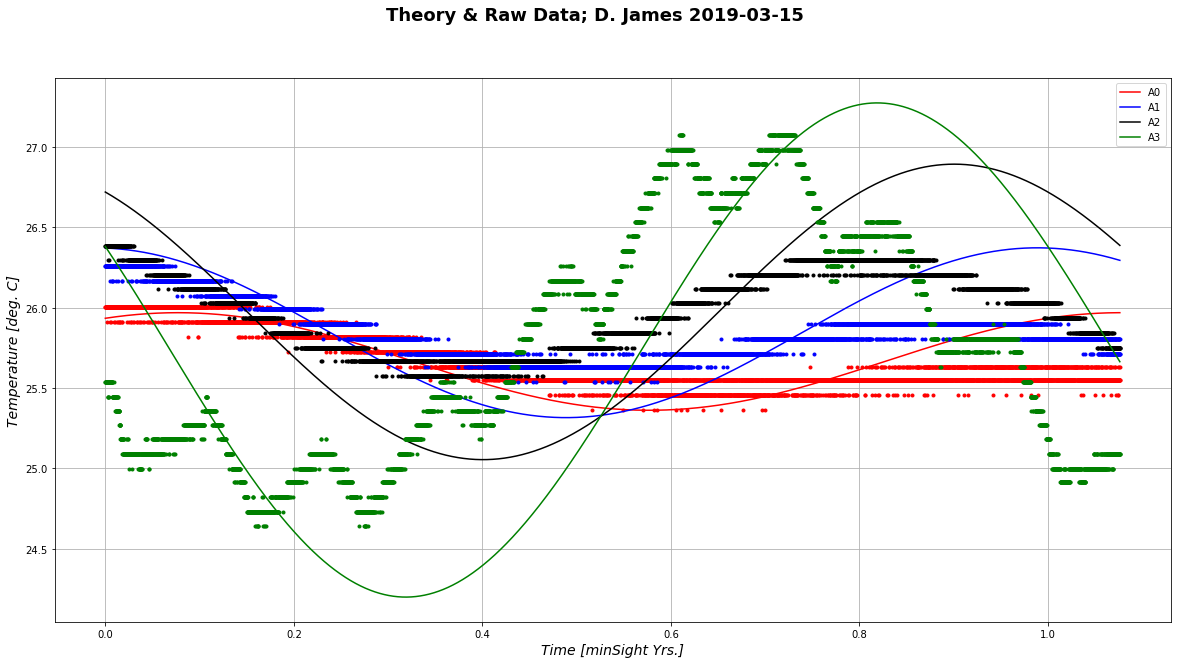

In [8]:
# plotting theoretical values with raw values
fig3 = plt.figure(figsize=(20,10))

fig3.suptitle('Theory & Raw Data; D. James '+now, fontsize='18', fontweight='bold')
plt.xlabel('Time [minSight Yrs.]', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature [deg. C]', fontsize='14', fontstyle='italic')
plt.grid(True)

styles = ['r','b','k','g']
rawSty = ['r.','b.','k.','g.']
labels = ['A0','A1','A2','A3']

for i in range(0,leng):
    plt.plot(time*convSecYr,theoryTemp[i],styles[i],label=labels[i])
    plt.plot(time*convSecYr,sandTemp[i],rawSty[i])
    
plt.legend()
fig3.show()
fig3.savefig(now+'plot2.png')

## Problem 3: Data Detrend
At this point in the project, any attempt to detrend my data made the raw data too flat, and nothing get extracted from it, so I decided to proceed without detrending it. Furthermore, the 2 channels taken out, A4 and A5, are removed since they were outside of the sand. A3 is my z0, lying right at the surface of the sand.

In [9]:
# creating logical vector to focus on window of data
timeYear = time*convSecYr
timeIndex = timeYear > 0.4
windowTime = timeYear[timeIndex]
windowTemp = []

for i in range(0,leng):
    windowTemp.append(sandTemp[i][timeIndex])

## Problem 4: Nonlinear Regression

In [10]:
from lmfit import minimize, Parameters

# importing necessary data
data = loadmat('20190305-2132data.mat')
Temp = data['channels']
time = data['time'][0]
roomTemp = Temp[4:]
sandTemp = Temp[0:4]
z = [42e-3,28e-3,14e-3,1e-3]
leng = sandTemp.shape[0]
meanTemp = zeros(leng)
for i in range(0,leng):
    meanTemp[i] = mean(Temp[i])

# function definition of the theoretical equation
def T(t,z,T0,kappa,period,deltaT,phase):
    z0 = 1e-3
    delta = sqrt(kappa*period/pi)
    
    return T0+deltaT*exp(-(z-z0)/delta)*sin(2*pi*t/period-(z-z0)/delta+phase)

# function definition to be fitted with theory 
def residual(params,temp,t):
    z = params['z']
    T0 = params['T0']
    kappa = params['kappa']
    period = params['period']
    deltaT = params['deltaT']
    phase = params['phase']
    
    return T(t,z,T0,kappa,period,deltaT,phase) - temp

In [11]:
results = []
invertTemp = []

# looping through the sets of parameters to minimize
# the minimize function from lmfit package doesn't
# seem to like that z was multiple values
# I loop through and get a set of values for each level of z rather
for i in range(0,leng):
    # parameters to be minimized
    params = Parameters()
    params.add('z',value=z[i])
    params.add('T0',value=meanTemp[i])
    params.add('kappa',value=3e-7)
    params.add('period',value=669*10)
    params.add('deltaT',value=1.6)
    params.add('phase',value=7*pi/8)
    
    # minimizing the residual function with the given parameters
    # in this case I chose to use the 'nelder' method to minimize
    result = minimize(residual,params,args=(sandTemp[i],time),nan_policy='propagate',method='nelder')
    
    # paramters found in this iteration appended to a list
    vals = [result.params['z'].value,result.params['T0'].value,result.params['kappa'].value,
           result.params['period'].value,result.params['deltaT'].value,result.params['phase'].value]
    results.append(vals)
    
    # inversion with found parameters
    invertTemp.append(T(time,results[i][0],results[i][1],results[i][2],results[i][3],results[i][4],results[i][5]))
    

In [12]:
# sorting through my list, so that rather
# grouped by z-level they are
# grouped by parameter type

sortResults = []
vals = []
i = 0
j = 1
while i < len(results):
    vals.append(results[i][j])
    
    if len(vals) == 4:
        sortResults.append(vals)
        if len(sortResults) != 5:
            i = 0
            j += 1
            vals = []
        elif len(sortResults) == 5:
            break
    else:
        i += 1
        
# with multiple sets of parameters
# I chose to find the mean of each value
# to display for each fitted parameter
meanResults = []
for i in sortResults:
    meanResults.append(mean(i))

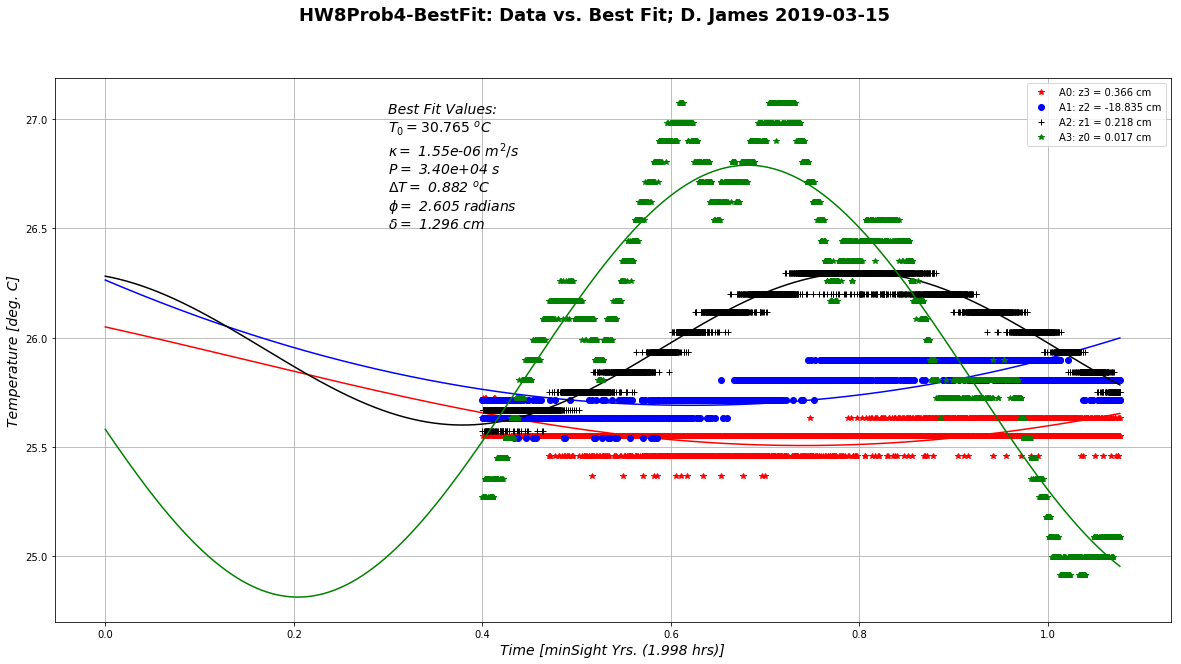

In [13]:
# plotting best fit with windowed data
fig4 = plt.figure(figsize=(20,10))

fig4.suptitle('HW8Prob4-BestFit: Data vs. Best Fit; D. James '+now, fontsize='18', fontweight='bold')
plt.xlabel('Time [minSight Yrs. (%4.3f hrs)]' % (len(time)/3600), fontsize='14', fontstyle='italic')
plt.ylabel('Temperature [deg. C]', fontsize='14', fontstyle='italic')
plt.text(.3,26.5,
         'Best Fit Values: \n' +
         r'$T_0={0: 4.3f}$ $^oC$'.format(meanResults[0])+'\n'+
         r'$\kappa =$ {0:1.2e} $m^2/s$'.format(meanResults[1])+'\n'+
         r'$P =$ {0:1.2e} s'.format(meanResults[2])+'\n'+
         r'$\Delta T =$ {0:4.3f} $^oC$'.format(meanResults[3])+'\n'+
         r'$\phi =$ {0:4.3f} radians'.format(meanResults[4])+'\n'+
         r'$\delta =$ {0:4.3f} cm'.format(sqrt(meanResults[1]*meanResults[2]/pi)*10), fontsize=14,fontstyle='oblique')

plt.grid(True)

styles = ['r','b','k','g']
rawSty = ['r*','bo','k+','g*']
labels = ['A0','A1','A2','A3']

tyr = time*convSecYr
for i in range(0,leng):
    plt.plot(tyr,invertTemp[i],styles[i])
    currentLabel = labels[i]+': z%i = %4.3f cm' % (3-i,results[i][0]*10)
    plt.plot(windowTime,windowTemp[i],rawSty[i],label=currentLabel)
    
plt.legend()
fig4.show()
fig4.savefig(now+'plot4.png')

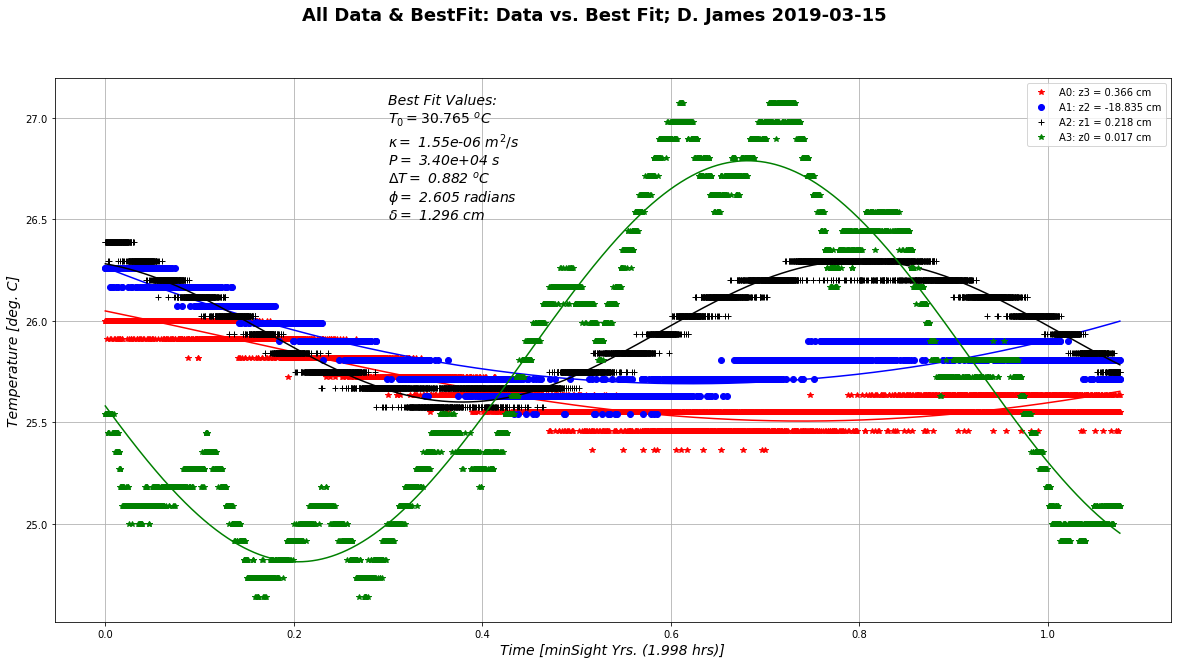

In [14]:
# plotting best fit with all data
fig4 = plt.figure(figsize=(20,10))

fig4.suptitle('All Data & BestFit: Data vs. Best Fit; D. James '+now, fontsize='18', fontweight='bold')
plt.xlabel('Time [minSight Yrs. (%4.3f hrs)]' % (len(time)/3600), fontsize='14', fontstyle='italic')
plt.ylabel('Temperature [deg. C]', fontsize='14', fontstyle='italic')
plt.text(.3,26.5,
         'Best Fit Values: \n' +
         r'$T_0={0: 4.3f}$ $^oC$'.format(meanResults[0])+'\n'+
         r'$\kappa =$ {0:1.2e} $m^2/s$'.format(meanResults[1])+'\n'+
         r'$P =$ {0:1.2e} s'.format(meanResults[2])+'\n'+
         r'$\Delta T =$ {0:4.3f} $^oC$'.format(meanResults[3])+'\n'+
         r'$\phi =$ {0:4.3f} radians'.format(meanResults[4])+'\n'+
         r'$\delta =$ {0:4.3f} cm'.format(sqrt(meanResults[1]*meanResults[2]/pi)*10), fontsize=14,fontstyle='oblique')

plt.grid(True)

styles = ['r','b','k','g']
rawSty = ['r*','bo','k+','g*']
labels = ['A0','A1','A2','A3']

tyr = time*convSecYr
for i in range(0,leng):
    plt.plot(tyr,invertTemp[i],styles[i])
    currentLabel = labels[i]+': z%i = %4.3f cm' % (3-i,results[i][0]*10)
    plt.plot(tyr,sandTemp[i],rawSty[i],label=currentLabel)
    
plt.legend()
fig4.show()

### Remarks
I ended up choosing the Nelder Method, because it seemed to give me the best inversion fit and the most reasonable values. Furthermore, the fit seemed to be doing well for finding $z$, but at $z_2$ (A1,blue) it gives a rather large negative value. The inverted line can also be seen trailing off more in the later end of the year. The $\kappa$ I found is slighlty larger than the theoretical one which could be due to the AC diffusiving over the sand. Similarly, my $\Delta T$ is also smaller than the given value which, I believe, is also due to the AC cooling the room. Moreover, A3 (green) is the surface level thermistor, and it can be seen from the graph that it has the largest amplitude. I also have a larger period, which may be due to the AC cooling the room and giving the model the idea that night was 'longer' than the 10 sec setup. Because $\delta$ has a proportional relationship with my period, it also becomes larger giving a larger skin depth value.

## Conclusion

The AC was a major factor in this setup, but it was enlightening to see how it did affect the model. If more time was available then addressing this would probably be collecting data for a longer period of time to see if a trend would have appeared. It is motivating to see that most of the $z$ values got larger as the depth increased, and that the values seem relatively close to the theoretical. The biggest mystery to me is $z_2$ for it having such a larger negative value.